# estimation of intrinsic reaction rate
Tim Tyree<br>
10.6.2022

In [2]:
# simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [4]:
from scipy.optimize import dual_annealing

# define module

# notae

$$
\frac{dP (n,t)}{dt} = \sum_r [W_r(n-r)P(n-r,t)-W_r(n)P(n,t)].
$$

For periodic boundary conditions, we are only concerned with $r=\pm2$.

$$
\frac{dP (n,t)}{dt} = W_{-2}(n-(-2))P(n-(-2),t)-W_{-2}(n)P(n,t) \\
    + W_{+2}(n-(+2))P(n-(+2),t)-W_{+2}(n)P(n,t)
$$

$$
\frac{dP (n,t)}{dt} = W_{-2}(n+2)P(n+2,t)-W_{-2}(n)P(n,t) \\
    + W_{+2}(n-2)P(n-2,t)-W_{+2}(n)P(n,t)
$$

The quasistationary state is defined by setting the left hand side to zero and solving for $P_{qs}(n)=P(n)$.

Base Case: n=2 particles

$$
0 \overset{!}{=} \frac{dP (2,t)}{dt} = W_{-2}(2+2)P(2+2)-W_{-2}(2)P(2) \\
    + W_{+2}(2-2)P(2-2)-W_{+2}(2)P(2) \\
    = W_{-2}(4)P(4)-W_{-2}(2)P(2) + 0-W_{+2}(2)P(2)
$$

Therefore, 

$$P(4) = P(2) \bigg(\frac{W_{-2}(2)+W_{+2}(2)}{W_{-2}(4)}\bigg).$$


With ibid as a quasistatic distribution, we are equipped with an ab initio estimator of the reaction rate in the limit of arbitrarily large attraction, as $a\rightarrow\infty$:

$$
\kappa \overset{?}{=} \sum_N \frac{w_-(N/A))}{N/A}P_{qs}(N)
$$

It seems $\kappa$ values closer to the unconcstrained MLE fit result from putting all the rate into one spiral tip.

$$
\kappa = \sum_N \frac{w_-(N/A))}{1/A}P_{qs}(N)
$$


# dev

In [5]:
wjr=recall_powerlaw_fits_to_full_models()


#recall the w pm rate densities
#DONE: get token inputs prepared
dict_fit_death_lr = dict(wjr['lr_pbc'])
dict_fit_death_fk = dict(wjr['fk_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


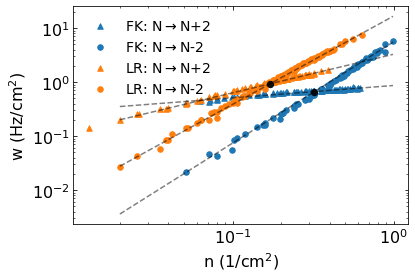

In [6]:
# input_fn = search_for_file()
# input_fn
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk'].sort_values(by='q')
lr=dict_wjr['lr'].sort_values(by='q')

birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

xv = np.arange(0.02, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

#compute the intersection point for both of the full models
index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
qstar_fk = xv[index_fk]
wstar_fk = yv_birth_fk[index_fk]
# index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
qstar_lr = xv[index_lr]
wstar_lr = yv_birth_lr[index_lr]
qstar_lr

# plt.plot(xv,(yv_birth_lr-yv_death_lr)**2)
# plt.show()
qstar_fk,qstar_lr

# fig,ax=plt.subplots()
fig,ax=plt.subplots(figsize=(6,4))
fontsize=16
# fontsize=20
alpha=0.9

# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30
df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
                         marker='^',
                         alpha=1.,label=r'FK: N$\rightarrow$N+2',s=markersize)
fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
                        marker='^',
                         alpha=1.,label=r'LR: N$\rightarrow$N+2',s=markersize)
lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)


#plot the powerlaw fits
ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)

#draw vertical dotted line up to the intersection point for both of the full models
ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)


# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# plt.legend(fontsize=16,frameon=False,loc='upper left')
plt.legend(fontsize=14,frameon=False,loc='upper left')
# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')

plt.show()

In [18]:
#select an area, A
L=5 #cm
# L=10 #cm
A=L**2
num_iter=40
A

25

Fenton-Karma (A=25 cm^2):
- mean num particles (qstar*A): 8.0750
- mean num particles (correct qs distr): 7.7257
- b.o.e. est. of mean termination time (correct qs distr): 15.1905 s


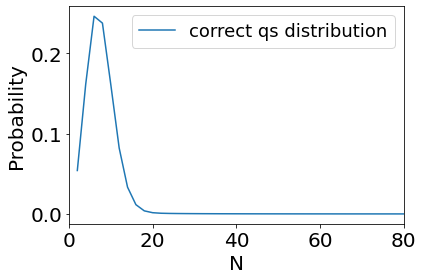

(7.725697909237681, 1.0, 40)

In [19]:
Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'


#estimate the quasistatic distribution
# L=5 #cm
# A=L**2
# num_iter=20
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
# n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=100.)

printing=True
#plot the wrong qs distribution (published) vs. the correct qs distribution
plt.plot(n_qs,prob_qs,label='correct qs distribution')
format_plot(xlabel='N',ylabel='Probability')
plt.legend(fontsize=fontsize)
# plt.xlim([0,40])
plt.xlim([0,80])

#print summary
xv = np.arange(0.02, 1,0.001)
qstar,wstar = comp_powerlaw_intersection(Mp,nup,Mm,num,xv=xv)
if printing:
    print(f"{model_name} ({A=:.0f} cm^2):")
    print(f"- mean num particles (qstar*A): {qstar*A:.4f}") 
    print(f"- mean num particles (correct qs distr): {np.sum(prob_qs*n_qs):.4f}")
#     print(f"- mean num particles (incorrect qs distr): {np.sum(prob_values_qs*n_values_qs)}")
    n=2
    tau = 1/(comp_Wm(2)*prob_qs[n_qs==n])[0]
    print(f"- b.o.e. est. of mean termination time (correct qs distr): {tau:.4f} s")
#     tau = 1/(comp_Wm(2)*prob_values_qs[n_values_qs==n])[0]
#     print(f"- b.o.e. est. of mean termination time (incorrect qs distr): {tau:.4f} s")

plt.show()

#TODO: dev unit test on qs distribution generating function
comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter)
np.sum(prob_qs*n_qs),np.sum(prob_qs),prob_qs.shape[0]

With ibid as a quasistatic distribution, we are equipped with an ab initio estimator of the reaction rate in the limit of arbitrarily large attraction, as $a\rightarrow\infty$:

$$
\kappa = \sum_N \frac{w_-(1/A))}{N/A}P_{qs}(N)
$$

<!-- $$
\kappa = \sum_N \frac{w_-(N/A))}{N/A}P_{qs}(N)
$$ -->

In [23]:
#average rate densities over quasistatic particle number distribution
km_sum=0
kp_sum=0
kb_sum=0
kd_sum=0
# for N,prob in zip(n_values_qs,prob_values_qs):  #wrong distro
for N,prob in zip(n_qs,prob_qs):
    Wm=comp_Wm(N)
    Wp=comp_Wp(N)
    n=N/A  # --> ~48 Hz for FK
#     n=1/A  # --> ~436 Hz for FK
    dkm=(Wm/n)*prob
    dkp=(Wp/n)*prob
    #record
    km_sum += dkm
    kp_sum += dkp
    kb_sum += dkp+dkm
    kd_sum += dkp-dkm

#TODO: print ibid. does kappa look reasonable?
print(f"kappa: {km_sum=:.4f} Hz")
print(f"kappa: {kp_sum=:.4f} Hz")
print(f"kappa: {kb_sum=:.4f} Hz")
print(f"kappa: {kd_sum=:.4f} Hz")

kappa: km_sum=49.1306 Hz
kappa: kp_sum=62.7679 Hz
kappa: kb_sum=111.8985 Hz
kappa: kd_sum=13.6373 Hz


In [24]:
#compute kappa versus A using ^that method, and then plot it!

Mp = dict_fit_birth_fk['M']
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'


A_values = np.arange(10,1000,5)
kappa_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    # n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=100.)

    #average rate densities over quasistatic particle number distribution
    km_sum=0
    kp_sum=0
    kb_sum=0
    kd_sum=0
    # for N,prob in zip(n_values_qs,prob_values_qs):  #wrong distro
    for N,prob in zip(n_qs,prob_qs):
        Wm=comp_Wm(N)
        Wp=comp_Wp(N)
#         n=N/A  # --> ~48 Hz for FK
        n=1/A  # --> ~436 Hz for FK
        dkm=(Wm/n)*prob
        dkp=(Wp/n)*prob
        #record
        km_sum += dkm
        kp_sum += dkp
        kb_sum += dkp+dkm
        kd_sum += dkp-dkm

    # #print ibid. does kappa look reasonable?
#     print(f"Area: {A} cm^2, kappa: {km_sum=:.4f} Hz")
    # # print(f"kappa: {kp_sum=:.4f} Hz")
    # # print(f"kappa: {kb_sum=:.4f} Hz")
    # print(f"kappa: {kd_sum=:.4f} Hz")
    
    kappa = float(km_sum)
    
    #record: 
    kappa_lst.append(kappa)
kappa_values=np.array(kappa_lst)

A_values_fk = A_values.copy()
kappa_values_fk = kappa_values.copy()

In [25]:
#compute kappa versus A using ^that method, and then plot it!

# Mp = dict_fit_birth_fk['M']
# nup = dict_fit_birth_fk['m']
# Mm = dict_fit_death_fk['M']
# num = dict_fit_death_fk['m']
# model_name='Fenton-Karma'

Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'


A_values = np.arange(10,1000,10)
kappa_lst=[]
for A in A_values:
    comp_Wp = get_comp_W(A,nup,Mp)
    comp_Wm = get_comp_W(A,num,Mm)
    # n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
    n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=100.)

    #average rate densities over quasistatic particle number distribution
    km_sum=0
    kp_sum=0
    kb_sum=0
    kd_sum=0
    # for N,prob in zip(n_values_qs,prob_values_qs):  #wrong distro
    for N,prob in zip(n_qs,prob_qs):
        Wm=comp_Wm(N)
        Wp=comp_Wp(N)
        #n=N/A  # --> ~48 Hz for FK
        n=1/A  # --> ~436 Hz for FK
        dkm=(Wm/n)*prob
        dkp=(Wp/n)*prob
        #record
        km_sum += dkm
        kp_sum += dkp
        kb_sum += dkp+dkm
        kd_sum += dkp-dkm

    # #print ibid. does kappa look reasonable?
#     print(f"Area: {A} cm^2, kappa: {km_sum=:.4f} Hz")
    # # print(f"kappa: {kp_sum=:.4f} Hz")
    # # print(f"kappa: {kb_sum=:.4f} Hz")
    # print(f"kappa: {kd_sum=:.4f} Hz")
    
    kappa = float(km_sum)
    
    #record: 
    kappa_lst.append(kappa)
kappa_values=np.array(kappa_lst)

A_values_lr = A_values.copy()
kappa_values_lr = kappa_values.copy()

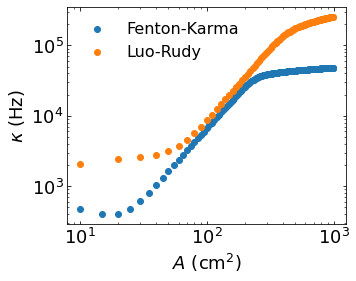

In [26]:
xlabel=r'$A$ (cm$^2$)'
ylabel=r'$\kappa$ (Hz)'
fontsize=18
figsize=(5,4)
fig,ax=plt.subplots(figsize=figsize)
ax.scatter(A_values_fk,kappa_values_fk,label='Fenton-Karma')
ax.scatter(A_values_lr,kappa_values_lr,label='Luo-Rudy')
format_plot(ax=ax,xlabel=xlabel,ylabel=ylabel,fontsize=fontsize)
AddLegend()

ax.legend(fontsize=16,frameon=False)
ax.tick_params(bottom=True,left=True,top=True, right=True,direction='in',which='both')

ax.set_xscale('log')
ax.set_yscale('log')

plt.show()

# attemping to estimate $\tau_\infty$ consistent with $\kappa$
$$
\frac{1}{\tau} \ge W_{-2}(2)P(2)
$$

$$
\tau \le 1/(W_{-2}(2)P(2))
$$


<!-- $$
\frac{1}{\tau} = W_{-2}(2)P(2)
$$ -->


Q: does the b.o.e. Estimate for tau serve as tauinfty?
A: no. 

# print the kappa estimates for either of the full models

In [44]:
A = 25 #cm^2
# A = 100 #cm^2
# num_iter=40
num_iter=20

In [45]:
Mp = dict_fit_birth_fk['M'] 
nup = dict_fit_birth_fk['m']
Mm = dict_fit_death_fk['M']
num = dict_fit_death_fk['m']
model_name='Fenton-Karma'

# Mp = dict_fit_birth_lr['M']
# nup = dict_fit_birth_lr['m']
# Mm = dict_fit_death_lr['M']
# num = dict_fit_death_lr['m']
# model_name='Luo-Rudy'


comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
#average rate densities over quasistatic particle number distribution
km_sum=0
kp_sum=0
kb_sum=0
kd_sum=0
# for N,prob in zip(n_values_qs,prob_values_qs):  #wrong distro
for N,prob in zip(n_qs,prob_qs):
    Wm=comp_Wm(N)
    Wp=comp_Wp(N)
    n=N/A  # --> ~48 Hz for FK
#     n=1/A  # --> ~436 Hz for FK
    dkm=(Wm/n)*prob
    dkp=(Wp/n)*prob
    #record
    km_sum += dkm
    kp_sum += dkp
    kb_sum += dkp+dkm
    kd_sum += dkp-dkm

#print ibid. does kappa look reasonable?
print(f"Area: {A} cm^2, kappa: {km_sum:.2f} Hz ({model_name})")
# print(f"kappa: {kp_sum=:.4f} Hz")
# print(f"kappa: {kb_sum=:.4f} Hz")
# print(f"kappa: {kd_sum=:.4f} Hz")
kappa_fk = float(km_sum)

#############################
# repeat for Luo-Rudy
#############################
# Mp = dict_fit_birth_fk['M']
# nup = dict_fit_birth_fk['m']
# Mm = dict_fit_death_fk['M']
# num = dict_fit_death_fk['m']
# model_name='Fenton-Karma'
Mp = dict_fit_birth_lr['M']
nup = dict_fit_birth_lr['m']
Mm = dict_fit_death_lr['M']
num = dict_fit_death_lr['m']
model_name='Luo-Rudy'

comp_Wp = get_comp_W(A,nup,Mp)
comp_Wm = get_comp_W(A,num,Mm)
n_qs,prob_qs = comp_quasistatic_distrib_paired_bdrates(comp_Wm,comp_Wp,num_iter=num_iter,freq_prev=1.)
#average rate densities over quasistatic particle number distribution
km_sum=0
kp_sum=0
kb_sum=0
kd_sum=0
# for N,prob in zip(n_values_qs,prob_values_qs):  #wrong distro
for N,prob in zip(n_qs,prob_qs):
    Wm=comp_Wm(N)
    Wp=comp_Wp(N)
    n=N/A  # --> ~48 Hz for FK
#     n=1/A  # --> ~436 Hz for FK
    dkm=(Wm/n)*prob
    dkp=(Wp/n)*prob
    #record
    km_sum += dkm
    kp_sum += dkp
    kb_sum += dkp+dkm
    kd_sum += dkp-dkm

#print ibid. does kappa look reasonable?
print(f"Area: {A} cm^2, kappa: {km_sum:.2f} Hz ({model_name})")
# print(f"kappa: {kp_sum=:.4f} Hz")
# print(f"kappa: {kb_sum=:.4f} Hz")
# print(f"kappa: {kd_sum=:.4f} Hz")
kappa_lr = float(km_sum)

Area: 25 cm^2, kappa: 48.64 Hz (Fenton-Karma)
Area: 25 cm^2, kappa: 167.02 Hz (Luo-Rudy)


In [115]:
# float(1/(comp_Wm(2)*prob_qs[n_qs==2]))

In [ ]:
# Area: 100 cm^2, kappa: 202.29 Hz (Fenton-Karma)
# Area: 100 cm^2, kappa: 500.57 Hz (Luo-Rudy)
# Area: 100 cm^2, kappa: 6608.97 Hz (Fenton-Karma)
# Area: 100 cm^2, kappa: 8597.22 Hz (Luo-Rudy)

# TODO(later): estimate alinear for fixed period

### estimates of rotational period from total self-crossings

Fenton-Karma:
- number_termination_events_considered: 20
- total number of loops observed longer than 10ms: 11293
- (number of particles considered: 22694)
- (mean number of loops per particle lifetime: 0.4976)
- number of particles considered with at least 1 loop: 12368
- mean number of loops per particle lifetime (at least 1 loop): 0.9131
- expected num. revolutions per lifetime: lifetime_fk/period_fk=0.9082

Luo-Rudy:
- number_termination_events_considered: 639
- total number of loops observed longer than 10ms: 10108
- (number of particles considered with at least 1 loop: 3644)
- (mean number of loops per particle lifetime (at least 1 loop): 2.7739)
- number of particles considered: 29402
- mean number of loops per particle lifetime: 0.3438
- expected num. revolutions per lifetime: lifetime_lr/period_lr=0.3427

src: http://localhost:8889/notebooks/computing%20rotational%20period%20of%20mean%20fortranic%20spiral%20trajectories.ipynb

0.3438
lifetime_lr/0.3427 = period_lr
period_lr = lifetime_lr/0.3438 
